<center><h1>Commentaires toxic<h1><center>

<p>Dans un monde rempli d'internet, tout le monde a la liberté d'écrire et de donner son opinion sur n'importe quelle plateforme de social media. Les gens choisissent généralement d'écrire leur opinion dans la section des commentaires et des fils de discussion d'un site Web, mais souvent, ils ne le font pas.</p>
<p>Il a été observé qu'au lieu de donner des conseils constructifs, les gens utilisent cette opportunité pour intimider ou abuser des autres et commencer à se battre les uns avec les autres dans les fils de discussion et la section des commentaires où ils vont parfois jusqu'à proférer des menaces et des insultes. </p>
<p>Pour identifier et restreindre spécifiquement ce type de commentaires, les sociétés d'internet travaillent régulièrement et cette compétition a été organisée sur un sujet similaire.</p>

<center><h2>Importation des packages<h2/><center/>

In [48]:
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from nltk.tokenize import TweetTokenizer  
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords

<center><h2>Visualisation des données<h2/><center/>

In [49]:
train=pd.read_csv("comment_train.csv")
test=pd.read_csv("comment_test.csv")

In [50]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [51]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


<p>Dans ce jeu de données, il y a 8 colonnes {id, comment text, Toxic, sever toxic, obscene, threat, identity hate, insult} présentes dans lesquelles 6 sont les labels et ce problème est un problème multi-label, pas un problème de classification multi-classe.
<p>Cela signifie qu'un commentaire peut appartenir à 1 ou plusieurs label à la fois, le plus élevé pouvant être 6 et le plus bas 1.
<p>La toute première observation est que tous les commentaires contiennent de nombreux signes de ponctuation et que la plupart d'entre eux sont en majuscules. Pour la modélisation, nous devons nettoyer les commentaires avant de les envoyer au modèle pour l'entraînement.
   

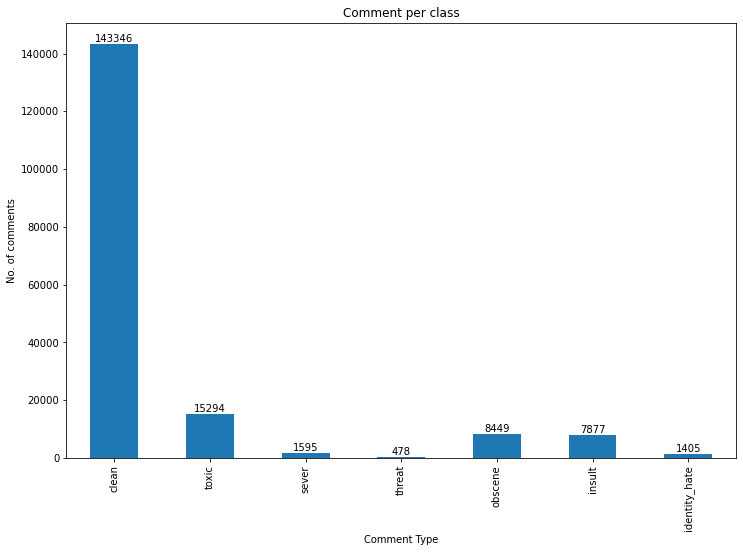

In [52]:
clean = len(train[(train["toxic"]==0) & (train["severe_toxic"]==0) & (train["obscene"]==0) & (train["threat"]==0) &(train["insult"]==0) & (train["identity_hate"]==0)]) 
toxic = len(train[train["toxic"]==1])
sever =  len(train[train["severe_toxic"]==1])
threat = len(train[train["threat"]==1]) 
obscene = len(train[train["obscene"]==1])
insult = len(train[train["insult"]==1])
identity_hate = len(train[train["identity_hate"]==1])
comment = [clean , toxic , sever , threat ,obscene , insult , identity_hate]

freq_series = pd.Series(comment)
x_labels = ["clean" , "toxic" , "sever" , "threat" ,"obscene" , "insult" , "identity_hate"]
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Comment per class')
ax.set_xlabel("Comment Type")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(x_labels)
rects = ax.patches


for rect , label in zip(rects , comment):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

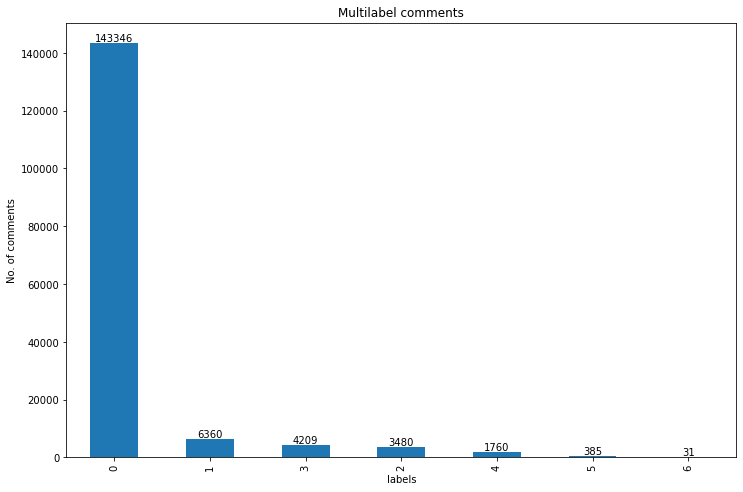

In [53]:
x = train[["toxic" , "severe_toxic"  ,"obscene" , "threat" , "insult" , "identity_hate"]].sum(axis = 1).value_counts()
key = x.keys()
value = x.values

fr = pd.Series(value)
plt.figure(figsize=(12, 8))
ax = fr.plot(kind='bar')
ax.set_title('Multilabel comments')
ax.set_xlabel("labels")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(key)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

Les résultats montrent que l'ensemble de données est fortement déséquilibré. Les commentaires propres dominent l'ensemble de données en ce qui concerne le nombre de valeurs par classe. D'autre part, les catégories de commentaires toxic sont en très petit nombre, même les catégories "threat, Sever toxic and Identity hate" ont un nombre significativement bas en termes de nombre par classe.

La plupart des commentaires partagent plusieurs labels, par exemple un commentaire peut appartenir à "Sever toxic" et "Threat ".
Par exemple pour le commentaire: "you are an idiot u don't have rights to live in our country u are an outsider and we will kill you all soon... ", A ce stade, nous allons  calculer le nombre total de toxicité différente qui peut être suivi par chaque commentaire.


In [54]:
train=train[0:5000]
test=test[0:5000]

In [55]:
train['comment_text'][12]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

## Tokenization

A ce stade, on va nettoyer les commentaires avant de les envoyer au modèle pour l'entraînement

In [56]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ',text)
    text = re.sub('\W', ' ',text)
    text = re.sub('\s+', ' ',text)   
    text = re.sub(r"\'", " ",text)
    return text

def clean( text):
    text = text.lower()
    text = re.sub("\\n","",text)
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",text)
    text = re.sub("\[\[.*\]","",text)
    text = re.sub(r'\r', ' ',text)
    text = re.sub(r'\n', ' ',text)
    text = re.sub('[^a-zA-Z0-9]', ' ',text)
    text = re.sub('\W', ' ',text)
    text = re.sub('\s+', ' ',text)   
    text = re.sub(r"\'", " ",text)
    return(text)

In [29]:
train['comment_text']=train['comment_text'].apply(lambda x :preprocess(x))
test['comment_text']=test['comment_text'].apply(lambda x :preprocess(x))

In [30]:
train['comment_text'][12]

'hey what is it talk what is it an exclusive group of some wp talibans who are good at destroying self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings '

In [31]:
X=train['comment_text'].fillna(' ')
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y=train[label_cols]

In [32]:
tfid = TfidfVectorizer(max_features=30000,stop_words='english')

In [33]:
X = tfid.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

<center><h1>Création des modèles<h1/><center>

### Logistic Regression

In [13]:
model = LogisticRegression(max_iter=200)

In [14]:
y_pred=pd.DataFrame(columns=['toxic','severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate'])
for i in label_cols:
    y_train_i = y_train[i]
    model.fit(X_train, y_train_i)
    y_pred_i = model.predict_proba(X_test)[:, 1]
    y_pred[i]=y_pred_i

In [15]:
print('Accuracy: ', 1-mean_squared_error(y_test,y_pred))

Accuracy:  0.9731726257527855


### Random Forest


In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1, class_weight="balanced", max_depth=10, n_estimators=150)

In [37]:
y_pred=pd.DataFrame(columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
for i in label_cols:
    y_train_i = y_train[i]
    model.fit(X_train, y_train_i)
    y_pred_i = model.predict_proba(X_test)[:, 1]
    y_pred[i]=y_pred_i

In [38]:
print('Accuracy: ', 1-mean_squared_error(y_test,y_pred))

Accuracy:  0.8404807503551796


### Decision tree


In [41]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()




In [42]:
y_pred=pd.DataFrame(columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
for i in label_cols:
    y_train_i = y_train[i]
    model.fit(X_train, y_train_i)
    y_pred_i = model.predict_proba(X_test)[:, 1]
    y_pred[i]=y_pred_i

In [43]:
print('Accuracy: ', 1-mean_squared_error(y_test,y_pred))

Accuracy:  0.9716666666666667


### MLPClassifier

In [44]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-8, hidden_layer_sizes=(2,8))


In [45]:
y_pred=pd.DataFrame(columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])
for i in label_cols:
    y_train_i = y_train[i]
    model.fit(X_train, y_train_i)
    y_pred_i = model.predict_proba(X_test)[:, 1]
    y_pred[i]=y_pred_i

In [46]:
print('Accuracy: ', 1-mean_squared_error(y_test,y_pred))

Accuracy:  0.974737485411385


## Conclusion

Une fois les données préparées, on utilise une régression logistique comme modèle de prédiction, le score MSE obtenu est de 0.014 sur notre jeu test. Le score obtenu sur Kaggle est de 0.977 ce qui est assez satisfaisant.